In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
import sklearn
import pandas as pd
import scipy.stats as stats

#from keras import Sequential
#from keras.layers import Dense
#from keras.wrappers.scikit_learn import KerasRegressor

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression



In [2]:
neuron_data = {}



In [3]:
files = sorted(os.listdir('../neuron_logs/train_data'))

In [4]:
with open(os.path.join('..', 'neuron_logs', 'train_data', 'output_20191013-181903.json'), 'r') as f:
    neuron_data = json.load(f)

1.0250968992248062


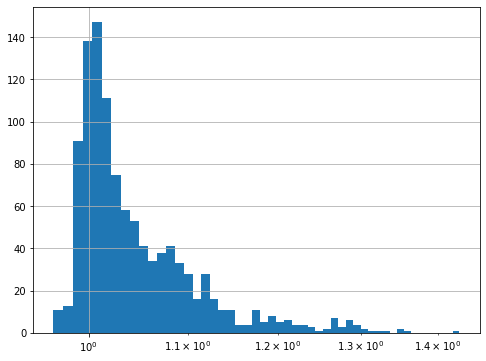

In [5]:
target = 'usefulness_acc'


target_thr = [neuron_data[e][neuron][target] for neuron in neuron_data['0'] for e in neuron_data  if e != '0' and ' ' in neuron and int(e) < 10]

threshold = np.percentile(target_thr, 50) 

print(threshold)

plt.figure(figsize = (8, 6), facecolor = 'w')
plt.xscale('log')
#plt.yscale('log')
plt.hist(target_thr, bins = 50)
plt.grid()

In [6]:
print(neuron_data['1']['0 0'].keys())
np.array(neuron_data['1']['3 0']['output_weights']).shape

dict_keys(['activations', 'usefulness_loss', 'usefulness_acc', 'depth', 'inverse_depth', 'width', 'input_weights', 'output_weights', 'reg_loss_in_layer'])


(10,)

In [7]:
def reduce_to_statistics(activations, labels, debug=False):
    sorted_data = []
    for i in range(10): #hardcoded MOFO
        sorted_data += [[]]
    for i, a in zip(labels, activations):
        sorted_data[i] += [a]
    if debug:
        return(sorted_data)
    statistics = []
    for ar in sorted_data:
        curr_stats = stats.describe(ar)
        statistics += [curr_stats.mean, curr_stats.variance, curr_stats.skewness, curr_stats.kurtosis, curr_stats.minmax[0],
                       curr_stats.minmax[1], curr_stats.nobs]
        #print(statistics)
    return(statistics)

In [164]:
features, labels = [], []
fin = 10
activations_no = 2000
for i, filename in enumerate(files[:]):
    with open(os.path.join('..', 'neuron_logs', 'train_data', filename), 'r') as f:
        print(filename)
        neuron_data = json.load(f)
    if i == 10:
        break
    for e in neuron_data.keys():
        if e == '0' or int(e) > fin:
            #print(e)
            continue
        for neuron in neuron_data[e]:
            if ' ' not in neuron:
                continue
            current_data = neuron_data[e][neuron]
            important_features = []
            important_features = current_data['activations'][:activations_no]
            important_features += reduce_to_statistics(current_data['activations'], neuron_data[e]['original_labels'])
            important_features += [current_data['depth']]
            important_features += [current_data['inverse_depth']]
            important_features += [current_data['width']]
            # important_features += [current_data['input_weights']]
            # important_features += [current_data['output_weights']]
            important_features += [current_data['reg_loss_in_layer']]
            features += [important_features]
            #labels += [current_data[target]]
            labels += [int(current_data[target] > threshold)]

output_20191013-181903.json
output_20191013-185216.json
output_20191015-203714.json
output_20191015-215448.json
output_20191015-231129.json


In [165]:
len(features)

6000

In [166]:
features = np.array(features)
labels = np.array(labels)

In [167]:
print(features.shape, labels.shape)

(6000, 2074) (6000,)


In [168]:
print(X_train.shape)

(1920, 2004)


In [128]:
import numpy as np
from sklearn.datasets import make_classification
from torch import nn
import torch.nn.functional as F
import torch.optim as optim


import skorch
from skorch import NeuralNetClassifier

from sklearn.preprocessing import StandardScaler

In [183]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=0)

X_train = X_train.astype(np.float32)
#y_train = y_train.astype(np.int64)
X_test = X_test.astype(np.float32)
#y_test = y_test.astype(np.int64)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

testscaler = StandardScaler()
scaler.fit(X_test)
X_test = scaler.transform(X_test)

In [189]:
print(f"{X_train.shape} {X_test.shape} {y_train.shape} {y_test.shape}")
clf = LogisticRegression(solver='liblinear', max_iter = 100).fit(X_train, y_train)
clf.score(X_test, y_test)

(4800, 2074) (1200, 2074) (4800,) (1200,)


0.9016666666666666

In [223]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            num_units=500,
            nonlin=F.relu,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.num_units = num_units
        self.nonlin = nonlin
        self.dropout = dropout

        self.dense0 = nn.Linear(X_train.shape[1], num_units)
        self.nonlin = nonlin
        self.dropout1 = nn.Dropout(dropout)
        self.dense1 = nn.Linear(num_units, num_units)
        self.dropout2 = nn.Dropout(dropout)
        self.dense2 = nn.Linear(num_units, 50)
        self.output = nn.Linear(50, 2)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout1(X)
        X = F.relu(self.dense1(X))
        X = self.dropout2(X)
        X = F.relu(self.dense2(X))
        X = F.softmax(self.output(X), dim=-1)
        return X

In [336]:
from skorch.callbacks import LRScheduler

lrscheduler = LRScheduler(monitor='train_loss',
            policy='ReduceLROnPlateau', # step_size=15, gamma=0.5)
            mode='min', factor=0.1, patience=10, verbose=True, 
            threshold=0.00001, threshold_mode='rel', 
            cooldown=0, min_lr=0, eps=1e-08)

from skorch.callbacks import Checkpoint

checkpoint = Checkpoint(
    f_params='best_model.pt', monitor='valid_loss_best')

from skorch.callbacks import EarlyStopping

earlystopping = EarlyStopping(
    monitor='train_loss',
    patience=20,
    threshold=0.0001,
    threshold_mode='rel',
    lower_is_better=True,)


In [341]:
net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=200,
    lr=0.07,
    optimizer=optim.SGD,
    optimizer__momentum=0.9,
    # callbacks=[skorch.callbacks.LRScheduler(skorch.callbacks.WarmRestartLR)],
    callbacks = [lrscheduler, checkpoint, earlystopping],
    warm_start=False
)

In [342]:
net.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        0.4941       0.8075        0.4419     +  1.3394
      2        0.4063       0.8117        0.4166     +  0.9472
      3        0.4011       0.8408        0.3802     +  1.0582
      4        0.3851       0.8325        0.3716     +  1.0210
      5        0.3704       0.8491        0.3600     +  1.2259
      6        0.3669       0.8512        0.3646        1.2238
      7        0.3620       0.8345        0.3717        1.1207
      8        0.3565       0.8533        0.3607        0.9516
      9        0.3578       0.8522        0.3439     +  0.9511
     10        0.3480       0.8543        0.3398     +  0.9445
     11        0.3280       0.8616        0.3368     +  0.9667
     12        0.3424       0.8699        0.3403        0.9562
     13        0.3436       0.8647        0.3252     +  1.0728
     14        0.3370       0.8564        0.3411       

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ClassifierModule(
    (dense0): Linear(in_features=2074, out_features=500, bias=True)
    (dropout1): Dropout(p=0.5, inplace=False)
    (dense1): Linear(in_features=500, out_features=500, bias=True)
    (dropout2): Dropout(p=0.5, inplace=False)
    (dense2): Linear(in_features=500, out_features=50, bias=True)
    (output): Linear(in_features=50, out_features=2, bias=True)
  ),
)

In [343]:
print(net.score(X_train, y_train))
print(net.score(X_test, y_test))

0.9227083333333334
0.8933333333333333


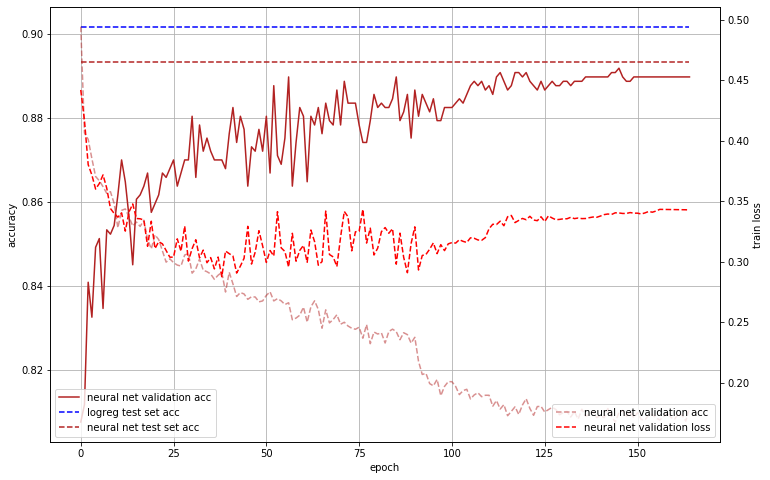

In [358]:
valid_acc = [x['valid_acc'] for x in net.history]
train_loss = [x['train_loss'] for x in net.history]
valid_loss = [x['valid_loss'] for x in net.history]
fig, ax1 = plt.subplots(figsize = (12, 8), facecolor = 'w')

ax1.plot(range(len(valid_acc)), valid_acc, color='firebrick', label = 'neural net validation acc')


ax1.plot(range(len(valid_acc)), [clf.score(X_test, y_test)]*len(valid_acc),  '--', color = 'blue', label = 'logreg test set acc')
ax1.plot(range(len(valid_acc)), [net.score(X_test, y_test)]*len(valid_acc), '--', color = 'firebrick', label = 'neural net test set acc')


ax2 = ax1.twinx()
ax2.plot(range(len(valid_acc)), train_loss, '--', alpha = 0.5, color='firebrick', label = 'neural net validation acc')
ax2.plot(range(len(valid_acc)), valid_loss, '--', color='red', label = 'neural net validation loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax2.set_ylabel('train loss')
ax1.grid(True)
ax1.legend(loc = 3)
ax2.legend(loc = 4)

In [10]:
clf.coef_

array([[-0.00345257,  0.11822586,  0.01406745, ...,  0.03848177,
         0.50044064,  0.0799585 ]])

In [12]:
clf.score(X_train, y_train)

1.0

In [28]:
np.argsort(np.abs(clf.coef_))
#clf.coef_[0][10000]

array([[ 534,  345,  490, ..., 1821, 2000, 2001]])

In [30]:
#sorted(np.abs(clf.coef_)[0], reverse=True)

In [31]:
clf.coef_[0]

array([-0.01809805,  0.00498394, -0.00645567, ..., -1.6790365 ,
       -0.0847954 , -0.16457551])

In [101]:
scores = {}
for c in [50, 100, 200, 500, 1000, 2500, 5000, 7500, 10000]:
    train, test = [], []
    for i, filename in enumerate(files[:2]):
        with open(os.path.join('..', 'neuron_logs', 'train_data', filename), 'r') as f:
            neuron_data = json.load(f)
        if i == 10:
            break
        for e in neuron_data.keys():
            if e == '0' or e > 5:
                continue
            for neuron in neuron_data[e]:
                if ' ' not in neuron:
                    continue
                current_data = neuron_data[e][neuron]
                important_features = []
                important_features += reduce_to_statistics(current_data['activations'], neuron_data[e]['original_labels'])
                #important_features = current_data['activations'][:c]
                important_features += [current_data['depth']]
                important_features += [current_data['inverse_depth']]
                important_features += [current_data['width']]
                # important_features += [current_data['input_weights']]
                # important_features += [current_data['output_weights']]
                important_features += [current_data['reg_loss_in_layer']]
                train += [important_features]
                test += [int(current_data[target] > threshold)]

    train = np.array(train)
    test = np.array(test)
    X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.2, random_state=0)
    print(f"{X_train.shape} {X_test.shape} {y_train.shape} {y_test.shape}")
    clf = LogisticRegression(solver='liblinear').fit(X_train, y_train)
    print(c, clf.score(X_test, y_test))
    scores[c] = clf.score(X_test, y_test)

(1920, 54) (480, 54) (1920,) (480,)
50 0.85625
(1920, 104) (480, 104) (1920,) (480,)
100 0.875
(1920, 204) (480, 204) (1920,) (480,)
200 0.9083333333333333
(1920, 504) (480, 504) (1920,) (480,)
500 0.9291666666666667
(1920, 1004) (480, 1004) (1920,) (480,)
1000 0.9333333333333333
(1920, 2504) (480, 2504) (1920,) (480,)
2500 0.9416666666666667
(1920, 5004) (480, 5004) (1920,) (480,)
5000 0.9479166666666666
(1920, 7504) (480, 7504) (1920,) (480,)
7500 0.9479166666666666
(1920, 10004) (480, 10004) (1920,) (480,)
10000 0.9416666666666667


Text(0.5, 1.0, 'Accuracy versus sample size from 10000 activations')

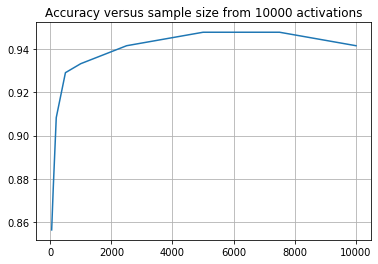

In [115]:
counts, accuracies = zip(*sorted(list(scores.items()), key = lambda x: x[0]))
plt.figure(facecolor = 'w')
plt.plot(counts, accuracies)
plt.grid()
plt.title('Accuracy versus sample size from 10000 activations')

In [10]:
with open(os.path.join('..', 'neuron_logs', 'train_data', 'output_20191013-181903.json'), 'r') as f:
    neuron_data = json.load(f)
    

Text(0.5, 1.0, "Distribution of some neuron's activations")

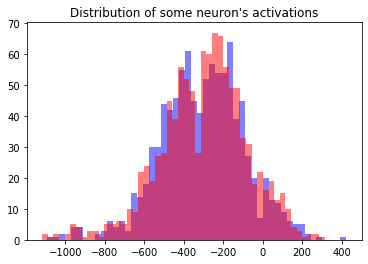

Initialization 0
  Iteration 10
Initialization converged: True
(0.8897592425346375, 5.814730093941428e-26)


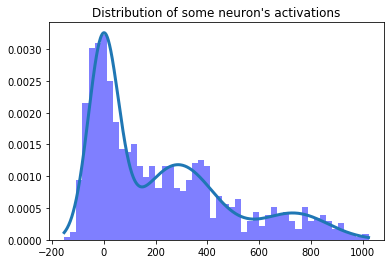

In [21]:
from sklearn.mixture import GaussianMixture

e = 25
num = 1
neuron = '2 24'
current_data = neuron_data[str(e)][neuron]
some_data = reduce_to_statistics(current_data['activations'], neuron_data[str(e)]['original_labels'], debug=True) 
plt.hist(some_data[num], bins = 50, alpha = 0.5, color = 'blue', density=True)
#plt.hist(some_data[num-2], bins = 50, alpha = 0.5, color = 'red')
plt.title('Distribution of some neuron\'s activations')

gmm = GaussianMixture(n_components=3, verbose = 1)
gmm.fit(np.array(some_data[num]).reshape(-1, 1))
gmm.means_


# Plot the data to which the GMM is being fitted
x = np.linspace(min(some_data[num]), max(some_data[num]), 1000).reshape(-1, 1)
y = np.exp(gmm.score_samples(x))

plt.plot(x, y, linewidth=3)

from scipy.stats import shapiro

print(shapiro(some_data[num][:2000]))

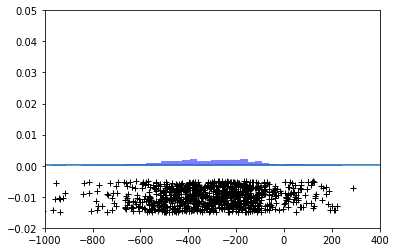

In [63]:
from scipy.stats import norm

np.random.seed(1)
X = np.array(some_data[num])[:, np.newaxis]

fig, ax = plt.subplots()


for kernel in ['gaussian']:
    kde = KernelDensity(kernel=kernel, bandwidth=1500).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax.plot(X_plot[:, 0], np.exp(log_dens), '-',
            label="kernel = '{0}'".format(kernel))

ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')

ax.set_xlim(-1000, 400)
ax.set_ylim(-0.02, 0.05)

ax.hist(some_data[num], bins = 50, alpha = 0.5, color = 'blue', density=True)

plt.show()

[[ 1.62434536]
 [-0.61175641]
 [-0.52817175]
 [-1.07296862]
 [ 0.86540763]
 [-2.3015387 ]
 [ 6.74481176]
 [ 4.2387931 ]
 [ 5.3190391 ]
 [ 4.75062962]
 [ 6.46210794]
 [ 2.93985929]
 [ 4.6775828 ]
 [ 4.61594565]
 [ 6.13376944]
 [ 3.90010873]
 [ 4.82757179]
 [ 4.12214158]
 [ 5.04221375]
 [ 5.58281521]]


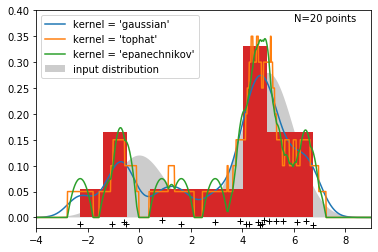

In [68]:

#----------------------------------------------------------------------
# Plot a 1D density example
N = 20
np.random.seed(1)
X = np.concatenate((np.random.normal(0, 1, int(0.3 * N)),
                    np.random.normal(5, 1, int(0.7 * N))))[:, np.newaxis]

print(X)
X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]

true_dens = (0.3 * norm(0, 1).pdf(X_plot[:, 0])
             + 0.7 * norm(5, 1).pdf(X_plot[:, 0]))

fig, ax = plt.subplots()
ax.fill(X_plot[:, 0], true_dens, fc='black', alpha=0.2,
        label='input distribution')

for kernel in ['gaussian', 'tophat', 'epanechnikov']:
    kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax.plot(X_plot[:, 0], np.exp(log_dens), '-',
            label="kernel = '{0}'".format(kernel))

ax.text(6, 0.38, "N={0} points".format(N))

ax.legend(loc='upper left')
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), '+k')
ax.hist(X, density=True)
ax.set_xlim(-4, 9)
ax.set_ylim(-0.02, 0.4)
plt.show()
